<a href="https://colab.research.google.com/github/ahm3dfaisal/Exploratory-Data-Analysis-on-3-Similar-Datasets/blob/main/EDA_Leisure_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up pyspark and other necssaary libraries.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq >/dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.1-bin-hadoop3'

In [ ]:
!pip install -q findspark
import findspark
findspark.init()
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import col
from pyspark.sql.functions import isnan,when,count
from pyspark.sql import functions as F

import datetime
import numpy as np

import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Test 2 Spark") \
    .getOrCreate()

Reading the data.

In [ ]:
path = "data/leisure.csv"
leisure_log = spark.read.csv(path, header = True)

In [ ]:
leisure_log.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- leisure: string (nullable = true)
 |-- longitude-lattitude: string (nullable = true)
 |-- All_tags: string (nullable = true)



Adding a name to the unnamed column.

In [ ]:
leisure_log = leisure_log.withColumnRenamed("_c0", "id")

In [ ]:
leisure_log.show()

+---------+--------------------+-------------+--------------------+--------------------+
|       id|                name|      leisure| longitude-lattitude|            All_tags|
+---------+--------------------+-------------+--------------------+--------------------+
|249132377|DLF Golf Links Go...|  golf_course|(77.1047102999998...|{'name': 'DLF Gol...|
|250737365|                null|         park|(80.2378664000000...| {'leisure': 'park'}|
|250979543|         Yoga Centre|sports_centre|(75.8870475, 31.5...|{'name': 'Yoga Ce...|
|280167017|       Black Thunder|   water_park|(76.9132247999999...|{'name': 'Black T...|
|280701513|Ootacamund Gymkha...|  golf_course|(76.6715780999999...|{'name': 'Ootacam...|
|285883594|Coimbatore Golf C...|  golf_course|(77.0205913000001...|{'name': 'Coimbat...|
|293675085|      Aberdeen Jetty|       marina|(92.7496630000002...|{'name': 'Aberdee...|
|293675089|   Phoenix Bay Jetty|       marina|(92.7342900000002...|{'name': 'Phoenix...|
|293675097|          

How many null values in dataset.

In [ ]:
null_count = leisure_log.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in leisure_log.columns])

In [ ]:
null_count.show()

+---+-----+-------+-------------------+--------+
| id| name|leisure|longitude-lattitude|All_tags|
+---+-----+-------+-------------------+--------+
|  0|27143|      0|              37876|       2|
+---+-----+-------+-------------------+--------+



Dropping the null values in longitude-lattitude columns only.

---



No. of entries in longitude-lattitude column before dropping.

In [ ]:
leisure_log.select("longitude-lattitude").count()

43689

Dropping the null values.

In [ ]:
leisure_log_2 = leisure_log.na.drop(subset=["longitude-lattitude"])

In [ ]:
leisure_log_2.select("longitude-lattitude").count()

5813

Checking for duplicates and ropping them.

In [ ]:
leisure_log_2.select("longitude-lattitude").distinct().count()

5811

In [ ]:
leisure_log_3 = leisure_log_2.dropDuplicates(["longitude-lattitude"])

In [ ]:
leisure_log_3.select("longitude-lattitude").count()

5811

Remove brackets from the longitude-lattitude column.

In [ ]:
leisure_log_4 = leisure_log_3.withColumn("longitude-lattitude", F.regexp_replace(F.regexp_replace(F.regexp_replace("longitude-lattitude", "\\)\\(", ""), "\\(", ""), "\\)", ""))

In [ ]:
leisure_log_4.show(truncate=False)

+----------+-----------------------------------+--------------+-------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id        |name                               |leisure       |longitude-lattitude                  |All_tags                                                                                                                                                                    

Splitting Longitude and lattitude into 2 columns

In [ ]:
from pyspark.sql.functions import split

In [ ]:
new_leisure_log = leisure_log_4.withColumn('longitude', split(leisure_log_4['longitude-lattitude'], ',') .getItem(0)) \
                            .withColumn('lattitude', split(leisure_log_4['longitude-lattitude'], ',') .getItem(1))


In [ ]:
new_leisure_log.show()

+----------+--------------------+--------------+--------------------+--------------------+-----------------+-------------------+
|        id|                name|       leisure| longitude-lattitude|            All_tags|        longitude|          lattitude|
+----------+--------------------+--------------+--------------------+--------------------+-----------------+-------------------+
|6852423121|               હરુદી|fitness_centre|69.05614949999985...|{'name': 'હરુદી',...|69.05614949999985| 23.640535499999885|
|3776405253|          Kamla Baug|          park|69.6239172000001,...|{'name': 'Kamla B...| 69.6239172000001|  21.63801860000007|
|4314218234|                null| sports_centre|70.05759260000013...|{'leisure': 'spor...|70.05759260000013| 22.478704800000077|
|4400079889|Destiny Pool & Sn...|fitness_centre|70.05791139999923...|{'name': 'Destiny...|70.05791139999923| 22.478921900000035|
|5681512116|pradarshan playgr...|    playground|70.05927319999971...|{'name': 'pradars...|70.0592

Drop the longitude-lattitude column.

In [ ]:
new_leisure_log = new_leisure_log.drop("longitude-lattitude")

In [ ]:
new_leisure_log.show()

+----------+--------------------+--------------+--------------------+-----------------+-------------------+
|        id|                name|       leisure|            All_tags|        longitude|          lattitude|
+----------+--------------------+--------------+--------------------+-----------------+-------------------+
|6852423121|               હરુદી|fitness_centre|{'name': 'હરુદી',...|69.05614949999985| 23.640535499999885|
|3776405253|          Kamla Baug|          park|{'name': 'Kamla B...| 69.6239172000001|  21.63801860000007|
|4314218234|                null| sports_centre|{'leisure': 'spor...|70.05759260000013| 22.478704800000077|
|4400079889|Destiny Pool & Sn...|fitness_centre|{'name': 'Destiny...|70.05791139999923| 22.478921900000035|
|5681512116|pradarshan playgr...|    playground|{'name': 'pradars...|70.05927319999971|  22.47018550000012|
|5681588784|                null| sports_centre|{'leisure': 'spor...|70.06883709999957| 22.467790300000157|
|5681588782|                

SQL queries.

---



In [ ]:
new_leisure_log.createOrReplaceTempView("leisure_log_table")

In [ ]:
spark.sql("SELECT * FROM leisure_log_table LIMIT 5").show()

+----------+--------------------+--------------+--------------------+-----------------+-------------------+
|        id|                name|       leisure|            All_tags|        longitude|          lattitude|
+----------+--------------------+--------------+--------------------+-----------------+-------------------+
|6852423121|               હરુદી|fitness_centre|{'name': 'હરુદી',...|69.05614949999985| 23.640535499999885|
|3776405253|          Kamla Baug|          park|{'name': 'Kamla B...| 69.6239172000001|  21.63801860000007|
|4314218234|                null| sports_centre|{'leisure': 'spor...|70.05759260000013| 22.478704800000077|
|4400079889|Destiny Pool & Sn...|fitness_centre|{'name': 'Destiny...|70.05791139999923| 22.478921900000035|
|5681512116|pradarshan playgr...|    playground|{'name': 'pradars...|70.05927319999971|  22.47018550000012|
+----------+--------------------+--------------+--------------------+-----------------+-------------------+



Find the count of the top lesiure places.

In [ ]:
leisure_frequency = spark.sql('''
                    SELECT leisure, count(*) as Frequency
                    FROM leisure_log_table
                    GROUP BY leisure
                    ORDER by Frequency DESC;
                    '''
                     )

In [ ]:
leisure_frequency.show()

+----------------+---------+
|         leisure|Frequency|
+----------------+---------+
|            park|     1798|
|      playground|      773|
|  fitness_centre|      580|
|          resort|      544|
|           pitch|      496|
|   sports_centre|      494|
|         fishing|      238|
|          garden|      196|
|         stadium|      159|
|   swimming_pool|      155|
|           dance|       58|
| fitness_station|       56|
|  nature_reserve|       52|
|      water_park|       24|
|          marina|       20|
|         slipway|       16|
|    beach_resort|       14|
|          common|       13|
|amusement_arcade|       12|
|           track|       10|
+----------------+---------+
only showing top 20 rows



In [ ]:
leisure = spark.sql('''
                    SELECT leisure
                    FROM leisure_log_table;
                    '''
                     )

Convert the lesiure to pandas to plot.

In [ ]:
leisure_pd = leisure.toPandas()

In [ ]:
leisures = leisure_pd['leisure'].value_counts()

In [ ]:
import seaborn as sns

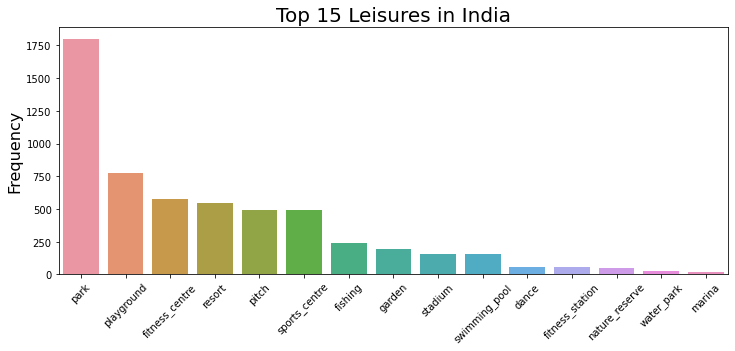

In [ ]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
g = sns.countplot(x='leisure',
                  data=leisure_pd[leisure_pd.leisure.isin(leisures[:15].index.values)],
                  order=leisures[:15].index.values,)
g.set_title("Top 15 Leisures in India", fontsize=20)
g.set_xlabel("", fontsize=16)
g.set_ylabel("Frequency", fontsize=16)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.show()

Select stadium from the lisure column and also names or tags with stadium.

In [ ]:
stadium = spark.sql('''
                    SELECT name, longitude, lattitude, leisure
                    FROM leisure_log_table
                    WHERE leisure = 'stadium' OR name LIKE '%stadium%' OR All_tags LIKE '%stadium%';
                    '''
                     )


In [ ]:
stadium.count()

175

In [ ]:
stadium_pd = stadium.toPandas()

Plot the map.

In [ ]:
pip install geopandas

In [ ]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [ ]:
import plotly.express as px

Convert to float to plot the coordinates.

In [ ]:
stadium_pd["longitude"] = stadium_pd["longitude"].astype(float)
stadium_pd["lattitude"] = stadium_pd["lattitude"].astype(float)

In [ ]:
geometry = [Point(xy) for xy in zip(stadium_pd['longitude'], stadium_pd['lattitude'])]
gdf = GeoDataFrame(stadium_pd, geometry = geometry)

In [ ]:
fig = px.scatter_geo(gdf,
                    lat=gdf.geometry.y,
                    lon=gdf.geometry.x,
                    hover_data=["name", "leisure"],
                    locationmode="country names"
                    )
fig.update_geos(fitbounds="locations")
fig.show()